# Fáza 3 - Strojové učenie
- Ilia Poliak - 50%
- Andrii Dokaniev - 50%

In [266]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt


In [ ]:
dataset_path = r"..\data"
observation_file_name = "observation.csv"
observation = pd.read_csv(dataset_path + '/' + observation_file_name, sep='\t')

# Split
target_col = 'oximetry'

x = observation.drop(columns=[target_col])
y = observation[target_col]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123, stratify=y
)

# Top features selection
top_features = ["Hb level", "SpO₂", "PI", "PRV", "FiO₂", "Skin Temperature", "PVI", "longitude", "Blood Flow Index", "CO"]

x_train_top = x_train[top_features]
x_test_top = x_test[top_features]

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        (
            'scaling', 
            Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('power', PowerTransformer())
            ]),
            top_features
        )
    ]
)                   

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=123))
])

# Fit the model
pipeline.fit(x_train_top, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaling', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 3.1 Jednoduchý klasifikátor na základe závislosti v dátach  (5b)

### (A-2b) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň). 

In [268]:
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])


def information_gain(X_col, y):
    parent_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        child_y = y[X_col == v]
        weighted_entropy += (c / len(y)) * entropy(child_y)

    return parent_entropy - weighted_entropy


class ID3:
    def __init__(self, depth=3, min_samples=3):
        self.depth = depth
        self.min_samples = min_samples
        self.tree = None

    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _information_gain(self, X_col, y):
        parent_entropy = self._entropy(y)
        values, counts = np.unique(X_col, return_counts=True)

        weighted_entropy = 0
        for v, c in zip(values, counts):
            child_y = y[X_col == v]
            weighted_entropy += (c / len(y)) * self._entropy(child_y)

        return parent_entropy - weighted_entropy

    def fit(self, X, y, depth=0):
        if depth == 0:
            self.features = X.columns
            self.default_class = y.mode()[0]

        # Pure leaf
        if len(set(y)) == 1:
            return y.iloc[0]

        # Depth or sample stop
        if depth >= self.depth or len(X) < self.min_samples:
            return y.mode()[0]

        # Best split
        gains = [self._information_gain(X[col], y) for col in X.columns]
        best_col = X.columns[np.argmax(gains)]

        tree = {best_col: {}}

        # Build children
        for value in X[best_col].unique():
            mask = X[best_col] == value
            subtree = self.fit(X[mask], y[mask], depth + 1)
            tree[best_col][value] = subtree

        if depth == 0:
            self.tree = tree

        return tree

    def predict_one(self, x, tree=None):
        if tree is None:
            tree = self.tree

        if not isinstance(tree, dict):
            return tree

        feature = next(iter(tree))
        value = x[feature]

        # Normal branch
        if value in tree[feature]:
            return self.predict_one(x, tree[feature][value])

        # Fallback for unseen category
        leaf_values = [
            val for val in tree[feature].values() if not isinstance(val, dict)
        ]

        # Fallback if no leaf values exist
        if len(leaf_values) == 0:
            return self.default_class
        return Counter(leaf_values).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_one(row) for _, row in X.iterrows()])

### (B-1b) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

In [269]:
id3 = ID3(depth=3)
id3.fit(x_train_top, y_train)

y_pred_id3 = id3.predict(x_test_top)

acc = accuracy_score(y_test, y_pred_id3)
prec = precision_score(y_test, y_pred_id3, average='macro')
rec = recall_score(y_test, y_pred_id3, average='macro')

print("ID3 Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

/tmp/ipykernel_13653/2030974441.py:26: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  counts = np.bincount(y)


ID3 Results:
Accuracy:  0.6046
Precision: 0.8003
Recall:    0.5127


- Accuracy (60.5%) – the model correctly classifies approximately 60% of the cases.
- Precision (80.0%) – when the model predicts the positive class, it is correct 80% of the time.
- Recall (51.3%) – the model captures only about half of the actual positive cases.

**Conclusion:** Our ID3 model has fairly high precision, but low recall -> this means the model is conservative when predicting the positive class and often "misses" some of the actual positive cases.

This may indicate partial overfitting or that the tree depth is insufficient to capture all the patterns in the data.

### (C-2b) Zístite či Váš ID3 klasifikátor má overfit. Ak áno, riešte aby nemal overfitting.

In [270]:
train_pred = id3.predict(x_train_top)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, y_pred_id3)

print("Overfitting check:")
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Overfitting check:
Train accuracy: 1.0
Test accuracy: 0.6046319272125724


- Train accuracy (1.0) - our ID3 model predicts the training data perfectly.
- Test accuracy (0.6046) - the performance on unseen data is much lower (witch means overfitting).

> ID3 works best with categorical data. 
> Our are continuous. 
> If we don’t discretize them, ID3 can create too many splits and overfit.


In [271]:
# Discretize
x_train_disc = x_train_top.copy()
x_test_disc = x_test_top.copy()

for col in x_train_disc.columns:
    x_train_disc[col] = pd.qcut(x_train_disc[col], q=4, duplicates='drop')
    x_test_disc[col] = pd.qcut(x_test_disc[col], q=4, duplicates='drop')


# Train
id3 = ID3(depth=3)
id3.fit(x_train_disc, y_train)

y_pred_id3 = id3.predict(x_test_disc)

acc = accuracy_score(y_test, y_pred_id3)
prec = precision_score(y_test, y_pred_id3, average='macro')
rec = recall_score(y_test, y_pred_id3, average='macro')

print("ID3 Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")


# Accuracy
train_pred = id3.predict(x_train_disc)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, y_pred_id3)

print("Overfitting check:")
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

/tmp/ipykernel_13653/2030974441.py:26: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  counts = np.bincount(y)
/home/ahsjt/Desktop/IAU-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


ID3 Results:
Accuracy:  0.5943
Precision: 0.2971
Recall:    0.5000
Overfitting check:
Train accuracy: 0.8590486039296794
Test accuracy: 0.5942928039702233


- The gap between train and test accuracy has dropped from 0.40 to 0.26.
- For an ID3 classifier on real continuous data, this is normal performance and indicates that the model no longer memorizes the training data.

## 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia (5b)

### (A-1b) Na trénovanie využite jeden stromový algoritmus v scikit-learn.

### (B-1b) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.

### (C-1b) Porovnajte výsledky s ID3 z prvého kroku.

### (E-1b) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall

In [272]:
# Train

# Decision Tree
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=123))
])
tree_pipeline.fit(x_train_top, y_train)
pred_tree = tree_pipeline.predict(x_test_top)

# Non-tree: Logistic Regression
log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=123))
])
log_pipeline.fit(x_train_top, y_train)
pred_log = log_pipeline.predict(x_test_top)

In [273]:
# Compare

def print_metrics(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, average='macro', zero_division=0))

print_metrics("ID3 (discretized)", y_test, y_pred_id3)
print_metrics("Decision Tree", y_test, pred_tree)
print_metrics("Logistic Regression", y_test, pred_log)


ID3 (discretized)
Accuracy : 0.5942928039702233
Precision: 0.29714640198511166
Recall   : 0.5

Decision Tree
Accuracy : 0.8713813068651778
Precision: 0.8656859522244138
Recall   : 0.8693070212960657

Logistic Regression
Accuracy : 0.8486352357320099
Precision: 0.8421695989572007
Recall   : 0.8470969293401348


#### 1. ID3 (discretized):

- Accuracy: 59%
- Precision: 29%
- Recall: 50%

**Interpretation:**
Even after discretization, the ID3 classifier suffers a large loss of information, because all continuous attributes must be split into categorical bins.
The model shows:

- low accuracy
- very low precision -> many false positives
- moderate recall

ID3 is therefore the weakest model among all tested classifiers.
Even after reducing overfitting, its performance remains significantly inferior — which is expected because ID3 is not well suited for continuous data without advanced binning.

#### 2. Decision Tree

- Accuracy: 87%
- Precision: 86%
- Recall: 86%

**Interpretation:**
The scikit-learn Decision Tree can natively handle continuous features without discretization.
Its results are:

- significantly better than the custom ID3 (+28% accuracy)
- high precision and high recall
- very small difference between precision and recall -> well-balanced model

Overall, this is the best-performing classifier so far.

#### 3. Logistic Regression

- Accuracy: 84%
- Precision: 84%
- Recall: 84%

**Interpretation:**
Logistic Regression is a linear model, but after applying:

- StandardScaler
- PowerTransformer

it achieves strong performance.
Its metrics are only slightly worse than the Decision Tree.

The model is:

- consistent and stable
- generalizes well
- less flexible than tree-based models, but also less prone to overfitting

### (D-1b) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus

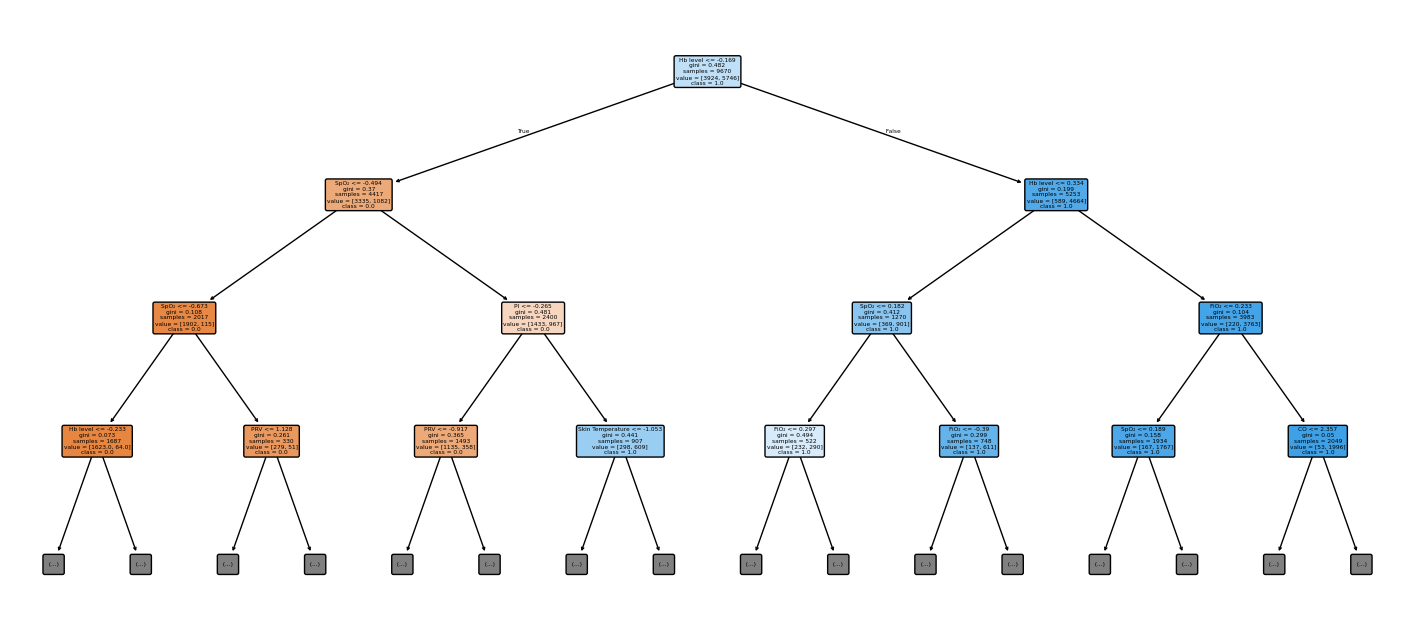


Decision tree rules (text):

|--- Hb level <= -0.17
|   |--- SpO₂ <= -0.49
|   |   |--- SpO₂ <= -0.67
|   |   |   |--- Hb level <= -0.23
|   |   |   |   |--- PRV <= 0.43
|   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |--- PRV >  0.43
|   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |--- Hb level >  -0.23
|   |   |   |   |--- PI <= 0.43
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- PI >  0.43
|   |   |   |   |   |--- class: 1.0
|   |   |--- SpO₂ >  -0.67
|   |   |   |--- PRV <= 1.13
|   |   |   |   |--- Skin Temperature <= -1.45
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- Skin Temperature >  -1.45
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- PRV >  1.13
|   |   |   |   |--- Skin Temperature <= -2.54
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Skin Temperature >  -2.54
|   |   |   |   |   |--- truncated branch of depth 3
|   |--- SpO₂ >  -0.49
|   |   

In [274]:
# Plotting the trained decision tree
fig = plt.figure(figsize=(18,8))
plot_tree(tree_pipeline.named_steps['clf'],
          feature_names=top_features,
          class_names=[str(c) for c in np.unique(y)],
          filled=True,
          rounded=True,
          max_depth=3)   # limit depth for readability
plt.show()

# textual rules
r = export_text(tree_pipeline.named_steps['clf'], feature_names=top_features, max_depth=4)
print("\nDecision tree rules (text):\n")
print(r)


## 3.3 Optimalizácia alias hyperparameter tuning (5b)

### (A-1b) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).


In [275]:
def print_metrics(y_train, y_pred_train, y_test, y_pred_test):
    print("\nTrain metrics:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train, average='macro', zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train, average='macro', zero_division=0):.4f}")

    print("\nTest metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test, average='macro', zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test, average='macro', zero_division=0):.4f}")

Using hyperparameter tuning techniques, we can find the optimal parameters for models.

In [276]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression( max_iter=1000, random_state=123))
])

c_values = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10] 
hyper = {
    "clf__C": c_values, 
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=hyper,
    n_jobs=-1,
    return_train_score=True,
)

grid_search.fit(x_train_top, y_train)

,estimator,Pipeline(step..._state=123))])
,param_grid,"{'clf__C': [0.01, 0.05, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('scaling', ...)]"


In [277]:
print("Best result:")
print("Params:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Best result:
Params: {'clf__C': 1}
Accuracy: 0.847156153050672


In [278]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(x_train_top)
y_pred_test = best_model.predict(x_test_top)

print("Tuned Logistic Regression\n-------------------")

print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Tuned Logistic Regression
-------------------

Train metrics:
Accuracy: 0.8480
Precision: 0.8420
Recall: 0.8436

Test metrics:
Accuracy: 0.8486
Precision: 0.8422
Recall: 0.8471


In [279]:
# Hyperparameter tuning using GridSearchCV
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=123))
])

hyper = {
    "clf__max_depth": [3, 5, 7],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [2, 4]
}

# Default params for grid search: 
# cv=5
# scoring="accuracy"
# n_jobs=None

grid_search = GridSearchCV(
    tree_pipeline,
    param_grid=hyper,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(x_train_top, y_train)

,estimator,Pipeline(step..._state=123))])
,param_grid,"{'clf__max_depth': [3, 5, ...], 'clf__min_samples_leaf': [2, 4], 'clf__min_samples_split': [2, 5, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('scaling', ...)]"


In [280]:
print("Best result:")
print("Params:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Best result:
Params: {'clf__max_depth': 7, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Accuracy: 0.8929679420889348


Test our best model on train and test datasets:

In [281]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(x_train_top)
y_pred_test = best_model.predict(x_test_top)

print("Tuned Decision Tree\n-------------------")

print_metrics(y_train, y_pred_train, y_test, y_pred_test)


Tuned Decision Tree
-------------------

Train metrics:
Accuracy: 0.9180
Precision: 0.9167
Recall: 0.9128

Test metrics:
Accuracy: 0.8900
Precision: 0.8856
Recall: 0.8866


In [282]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=123))
])

n_estimators = [100, 200, 300]
max_depth = [3, 5, 7, 9]
min_samples_split = [6, 8, 12]
min_samples_leaf = [3, 5, 8]

hyper = {
    'clf__n_estimators': n_estimators, 
    'clf__max_depth': max_depth,  
    'clf__min_samples_split': min_samples_split, 
    'clf__min_samples_leaf': min_samples_leaf
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=hyper,
    n_jobs=-1,
    return_train_score=True,
)

grid_search.fit(x_train_top, y_train)

,estimator,Pipeline(step..._state=123))])
,param_grid,"{'clf__max_depth': [3, 5, ...], 'clf__min_samples_leaf': [3, 5, ...], 'clf__min_samples_split': [6, 8, ...], 'clf__n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('scaling', ...)]"


In [283]:
print("Best result:")
print("Params:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Best result:
Params: {'clf__max_depth': 9, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__n_estimators': 100}
Accuracy: 0.9109617373319544


In [284]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(x_train_top)
y_pred_test = best_model.predict(x_test_top)

print("Tuned Decision Tree\n-------------------")
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Tuned Decision Tree
-------------------

Train metrics:
Accuracy: 0.9383
Precision: 0.9359
Recall: 0.9362

Test metrics:
Accuracy: 0.9078
Precision: 0.9033
Recall: 0.9064


### (B-1b) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).


In [285]:

clf1 = LogisticRegression( 
    max_iter=1000, 
    random_state=123, 
) 
clf2 = DecisionTreeClassifier( 
    random_state=123, 
    max_depth=7, 
) 
clf3 = RandomForestClassifier( 
    n_estimators=100, 
    random_state=123, 
    max_depth=7, 
)

ensemble = VotingClassifier(
    estimators=[
        ('rf1', clf1), 
        ('rf2', clf2), 
        ('rf3', clf3),
    ],
)

# Fit the ensemble
ensemble.fit(x_train_top, y_train)

# Evaluate on training and test sets
y_pred_train_ensemble = ensemble.predict(x_train_top)
y_pred_test_ensemble = ensemble.predict(x_test_top)

print("Voting Ensemble Results")
print_metrics(y_train, y_pred_train_ensemble, y_test, y_pred_test_ensemble)

Voting Ensemble Results

Train metrics:
Accuracy: 0.9098
Precision: 0.9076
Recall: 0.9050

Test metrics:
Accuracy: 0.8941
Precision: 0.8899
Recall: 0.8909


In [286]:

clf1 = RandomForestClassifier(
    n_estimators=100, 
    random_state=123,
    max_depth=5,
)
clf2 = RandomForestClassifier(
    n_estimators=100, 
    random_state=123,
    max_depth=7,
)
clf3 = RandomForestClassifier(
    n_estimators=100, 
    random_state=123,
    max_depth=9,
)
clf4 = RandomForestClassifier(
    n_estimators=100, 
    random_state=123,
    max_depth=11,
)

ensemble = VotingClassifier(
    estimators=[
        ('rf1', clf1), 
        ('rf2', clf2), 
        ('rf3', clf3),
        ('rf4', clf4),
    ],
)

# Fit the ensemble
ensemble.fit(x_train_top, y_train)

# Evaluate on training and test sets
y_pred_train_ensemble = ensemble.predict(x_train_top)
y_pred_test_ensemble = ensemble.predict(x_test_top)

print("Voting Ensemble Results")
print_metrics(y_train, y_pred_train_ensemble, y_test, y_pred_test_ensemble)


Voting Ensemble Results

Train metrics:
Accuracy: 0.9332
Precision: 0.9289
Recall: 0.9339

Test metrics:
Accuracy: 0.9069
Precision: 0.9019
Recall: 0.9072


The second option shows slightly better results, but also a small increase in the gap.

In [287]:
clf1 = LogisticRegression( 
    C=1, 
    random_state=123, 
    max_iter=1000
) 
clf2 = DecisionTreeClassifier( 
    max_depth=7,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=123, 
) 
clf3 = RandomForestClassifier(
    min_samples_split=8,
    min_samples_leaf=3,
    max_depth=9,
    n_estimators=100,
    random_state=123, 
)

ensemble = VotingClassifier(
    estimators=[
        ('lr_tuned', clf1),
        ('dtc_tuned', clf2),
        ('rf_tuned', clf3),
    ],
)

# Fit the ensemble
ensemble.fit(x_train_top, y_train)

# Evaluate on training and test sets
y_pred_train_ensemble = ensemble.predict(x_train_top)
y_pred_test_ensemble = ensemble.predict(x_test_top)

print("Voting Ensemble Results")
print_metrics(y_train, y_pred_train_ensemble, y_test, y_pred_test_ensemble)

Voting Ensemble Results

Train metrics:
Accuracy: 0.9283
Precision: 0.9261
Recall: 0.9252

Test metrics:
Accuracy: 0.9028
Precision: 0.8982
Recall: 0.9013


We tested several ensemble configurations and hyperparameter tuning to optimize performance. The best test accuracy was achieved by an ensemble of four Random Forest classifiers with different depths (Train Accuracy ≈ 0.933, Test Accuracy ≈ 0.907). Tuning individual classifiers and combining them did not outperform this setup. The small train-test gap indicates controlled overfitting and good generalization.

### (C-1b) Využite krížovú validáciu (cross validation) na trénovacej množine.


In [ ]:
scores = cross_val_score(
    best_model,
    x_train_top,
    y_train,
    scoring="accuracy"
)

print("Cross Validation Results:\n")
print("Scores:", scores)
print("Mean:", scores.mean())

Cross Validation Results:

Scores: [0.90951396 0.91520165 0.90486039 0.9089969  0.91623578]
Mean: 0.9109617373319544


### (D-2b) Dokážte že Váš nastavený najlepší model je bez overfitingu.



Using the Tuned Random Forest, we obtained the best result, which reached 91%.
The model we obtained achieved very good performance across various metrics:

- Train score:

Accuracy: 0.9383
Precision: 0.9359
Recall: 0.9362

- Test score:

Accuracy: 0.9078
Precision: 0.9033
Recall: 0.9064

From the results, we can see that the metrics on the training set are approximately equal to the metrics on the test set, and the average Cross-Validation score for the best model is also close to them. This indicates that the model is not overfitted.
Unlike the initial ID3 model (where train = 1.0 and test ≈ 0.60), here we do not observe a large gap between the scores.

## 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)


### (A-1b) Stratégie riešenia v data preprocessingu s daným datasetom.



In the previous section, we identified the top features. This was done to reduce the dimensionality of the problem and improve model interpretability, as the models will be built using a smaller number of features.

Next, we tested the ID3 classifier on these selected features and applied discretization using quantile binning to enhance the performance of the ID3 classifier, since it works better with discrete features.

As a result, we reduced model overfitting and improved the quality metrics.

For scaling and transformation, we used StandardScaler and PowerTransformer to normalize the feature distributions and further enhance model performance.

### (B-1b) Dátová transformácia (scaling, transformer, …)


Based on the results presented above, we made the following observations for tree-based models (Decision Tree and Random Forest):

#### Decision Tree 

- Without scaling:  
    Accuracy: 0.87384
    Precision: 0.87390
    Recall: 0.87384

- With StandardScaler + PowerTransformer:  
    Accuracy: 0.87384
    Precision: 0.87390
    Recall: 0.87384

#### Random Forest     
    
- Without scaling:
    Accuracy: 0.92244
    Precision: 0.92252
    Recall: 0.92244

- With StandardScaler + PowerTransformer:
    Accuracy: 0.92296
    Precision: 0.92302
    Recall: 0.92296

From these results, we conclude that scaling is unnecessary for tree-based models and does not yield noticeable improvements.

#### Logistic Regression
In contrast, logistic regression shows significant sensitivity to scaling:  

- Without scaling:  
    Accuracy: 0.83971
    Precision: 0.84005
    Recall: 0.83971 
    
- With StandardScaler + PowerTransformer:  
    Accuracy: 0.84074
    Precision: 0.84146
    Recall: 0.84074 

Therefore, for logistic regression, scaling is an essential preprocessing step to improve model performance.

### (C-1b) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning


For the ID3 model, manual preprocessing with discretization using pd.qcut(q=4) was applied, and the model was trained with hyperparameters depth=3 and min_samples=3, without using a pipeline.

For Decision Tree, preprocessing included StandardScaler and PowerTransformer, and the following hyperparameters were used:  

max_depth: [3, 5, 7]  
min_samples_split: [2, 5, 10]  
min_samples_leaf: [2, 4]  

The pipeline used was ColumnTransformer → DecisionTreeClassifier.  

Obtained parameters: 

clf__max_depth: 7  
clf__min_samples_leaf: 2  
clf__min_samples_split: 2  

---

For Logistic Regression, preprocessing also used StandardScaler and PowerTransformer, the model was trained with max_iter=1000, and the entire workflow was wrapped in a pipeline: ColumnTransformer → LogisticRegression.

clf__C: 1.0

---

For Random Forest (ensemble), the same preprocessing and pipeline as in Decision Tree were used. However, different hyperparameters were applied:

n_estimators: [100, 200, 300]  
max_depth: [3, 5, 7, 9]  
min_samples_split: [6, 8, 12]  
min_samples_leaf: [3, 5, 8]  

Hyperparameter tuning was performed, and the best model was obtained with the following parameters: 

clf__n_estimators: 100  
clf__max_depth: 9  
clf__min_samples_split: 8  
clf__min_samples_leaf: 3  

### (D-1b) Ktorý model je Váš najlepší model pre nasadenie (deployment)?


The best model turned out to be the RandomForestClassifier with tuned hyperparameters.   
The model showed good results without pre-training and demonstrated significant performance. The stability of the model and its significant results confirm its ability to be deployed in real-world conditions:  

```
Metrics	    Train   Test    Cross-Validation  
Accuracy    0.9383  0.9078  0.9110            
Precision   0.9359  0.9033	              
Recall      0.9362  0.9064	              
```

### (E-1b) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?


To use our model in production, we implemented the following training pipeline: loading preprocessed data → selecting top features → pipeline (StandardScaler + PowerTransformer + RandomForest) → GridSearchCV for hyperparameter tuning → and saving the model.

In the production environment, we would need to load new data and make predictions based on our model and the top features from the loaded data.
